# ERP inferences with EasyEEG package

Yang, J., Zhu, H., & Tian, X. (2018). Group-Level Multivariate Analysis in EasyEEG Toolbox: Examining the Temporal Dynamics Using Topographic Responses. *Frontiers in neuroscience*, *12*, 468. https://doi.org/10.3389/fnins.2018.00468

## Imports

In [1]:
import easyEEG
import mne
from mne import find_events, Epochs, pick_types, read_evokeds
import pandas as pd
import numpy as np
import matplotlib

import os
import re
import glob
import os
import ast

EasyEEG loaded.


## Parameters

In [2]:
tmin, tmax = -0.1, 0.6  # Start and end of the segments
signal_frequency = 256

## Load data

In [3]:
dir_path = os.path.dirname(os.path.abspath(""))

In [5]:
def load_epochs_from_file(file):
    """Load epochs from a header file.

    Args:
        file: path to a header file (.vhdr)

    Returns:
        mne Epochs

    """
    # Import the BrainVision data into an MNE Raw object
    raw = mne.io.read_raw_brainvision(file)

    # Construct annotation filename
    annot_file = file[:-4] + "vmrk"

    # Read in the event information as MNE annotations
    annotations = mne.read_annotations(annot_file)

    # Add the annotations to our raw object so we can use them with the data
    raw.set_annotations(annotations)

    # Map with response markers only
    event_dict = {
        "Stimulus/RE*ex*1_n*1_c_1*R*FB": 10004,
        "Stimulus/RE*ex*1_n*1_c_1*R*FG": 10005,
        "Stimulus/RE*ex*1_n*1_c_2*R": 10006,
        "Stimulus/RE*ex*1_n*2_c_1*R": 10007,
        "Stimulus/RE*ex*2_n*1_c_1*R": 10008,
        "Stimulus/RE*ex*2_n*2_c_1*R*FB": 10009,
        "Stimulus/RE*ex*2_n*2_c_1*R*FG": 10010,
        "Stimulus/RE*ex*2_n*2_c_2*R": 10011,
    }

    # Map for merged correct/error response markers
    merged_event_dict = {"correct_response": 0, "error_response": 1}

    # Reconstruct the original events from Raw object
    events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

    # Merge correct/error response events
    merged_events = mne.merge_events(
        events,
        [10004, 10005, 10009, 10010],
        merged_event_dict["correct_response"],
        replace_events=True,
    )
    merged_events = mne.merge_events(
        merged_events,
        [10006, 10007, 10008, 10011],
        merged_event_dict["error_response"],
        replace_events=True,
    )

    epochs = []

    # Read epochs
    epochs = mne.Epochs(
        raw=raw,
        events=merged_events,
        event_id=merged_event_dict,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        reject_by_annotation=True,
        preload=True,
    )
        
    if ((epochs['correct_response']._data.shape[0] > 2) and (epochs['error_response']._data.shape[0] > 2)):
        epochs = epochs.equalize_event_counts(['correct_response', 'error_response'])[0]

        participant_id = re.match(r".*_(\w+).*", file).group(1)
        # print(epochs)

        epochs.save(f'data_eegPip/{participant_id}-epo.fif', overwrite=True)
        # print(f' EXTRACTED {participant_id}\n')

In [6]:
def create_df_data():
    dir_path = os.path.dirname(os.path.abspath(""))
    header_files_glob = os.path.join(dir_path, "rumination_project/erpinator/data/responses/*.vhdr")
    header_files = glob.glob(header_files_glob)

    # header_files = sorted(header_files)
    
    for file in header_files:
        #  load eeg data for given participant
        # print(file)
        load_epochs_from_file(file)

In [7]:
# # load data and save as .fif files

# create_df_data()

## Save data in EasyEEG format

In [ ]:
# fif_files_glob = os.path.join(os.path.abspath(""), "data_eegPip/*.fif")
# print(fif_files_glob)
# fif_files_list = glob.glob(fif_files_glob)

# epochs = easyEEG.io.load_mne_fif(fif_files_list)
# epochs.save('data_eegPip/data.h5')

## Load data in EasyEEG format

In [ ]:
epochs = easyEEG.io.load_epochs('data_eegPip/data.h5')

---
## Topographic differences

Significant channels are highlighted in white

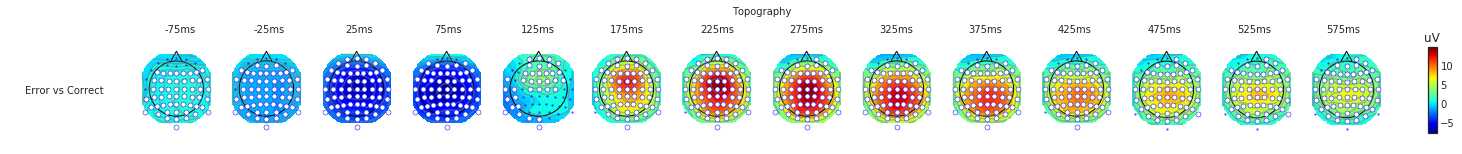

<Figure size 432x288 with 0 Axes>

In [3]:
script = {'conditions': 'Error vs Correct:error_response&correct_response',
         'timepoints': '-100~600'}
e = epochs.extract(script)

topo = e.topography(win_size='50ms')
topo.plot()

---
## ERP visualization

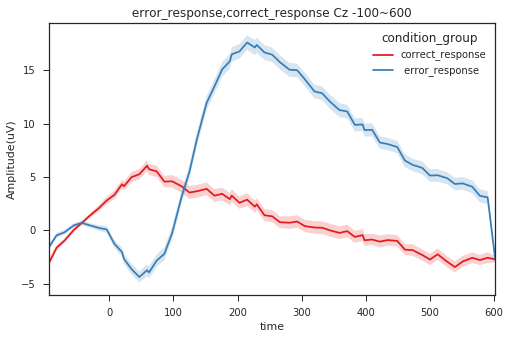

<Figure size 432x288 with 0 Axes>

In [7]:
# ERP at Cz
script = {'conditions': 'correct_response, error_response',
          'channels': 'Cz',
          'timepoints': '-100~600'}

erp = epochs.extract(script).ERP()
erp.default_plot_params['style']='ticks'
erp.plot()

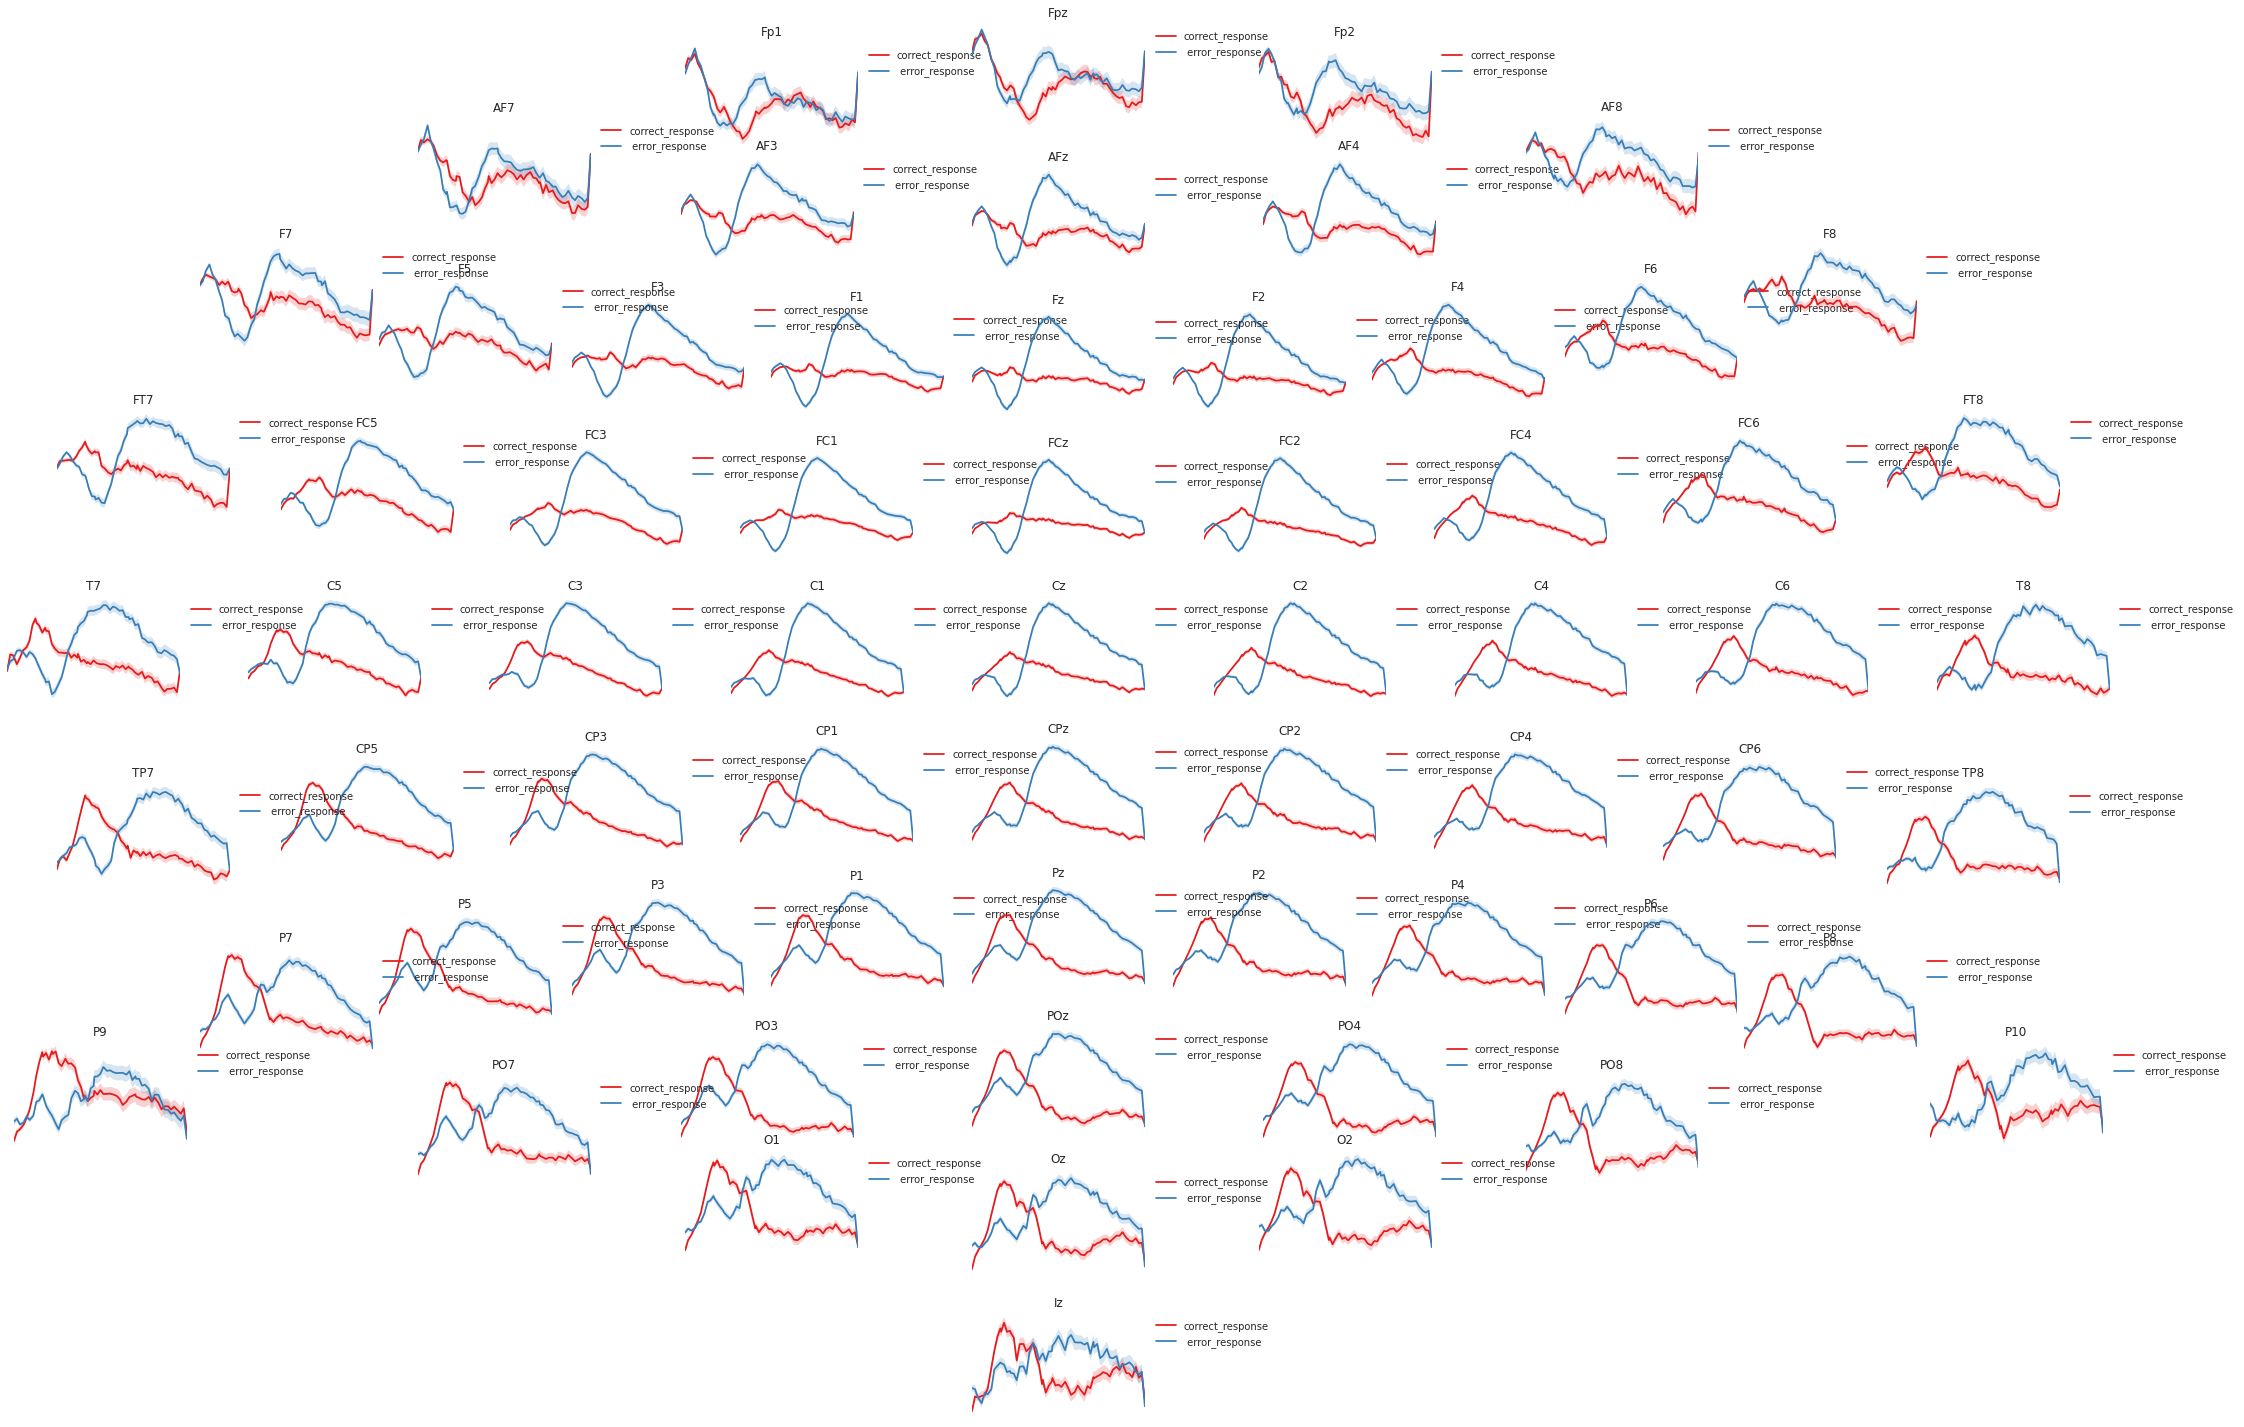

<Figure size 432x288 with 0 Axes>

In [6]:
# ERP at all sensors
script = {'conditions': 'correct_response, error_response',
          'channels': 'each',
          'timepoints': '-100~600'}
epochs.extract(script).topo_ERPs().plot()

---
## Global field power (GFP) 

Basically, GFP is a summary statistics of response magnitude from all sensors on a topography, which is in the form of variance of response magnitude and mathematically equals the root mean square (RMS) of all mean-referenced sensor values. GFP reflects the overall energy fluctuation of distributed electric potentials across all sensors at a specific time point.

100% 35/35 [00:00<00:00, 322.87it/s]


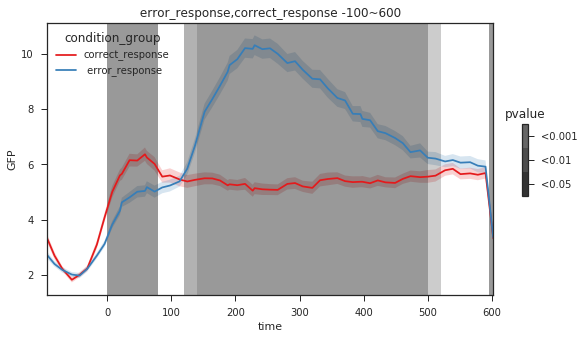

In [11]:
scripts = [{'conditions': 'correct_response, error_response',
           'timepoints': '-100~600'}]

for idx,script in enumerate(scripts):
    gfp = epochs.extract(script).GFP(compare=True)
    gfp.default_plot_params['style']='ticks' # remove the backgroud color for paper publication
    gfp.plot()

----
## TANOVA

TANOVA is a statistical analysis on a measure of similarity between topographies. This topographic similarity measure, called “angle measure” (Tian and Huber, 2008), where the topographic pattern similarity is quantified by a high-dimensional angle between two topographies.

 The critical step in TANOVA is to generate a null distribution. In EasyEEG (0.8.4.1), we provided three different strategies to generate the null distribution of the angle measure cosine values.

**Strategy 1:**

    1. Put all subjects' data into one pool regardless of experimental conditions.
    2. Shuffle the pool and randomly re-assign a condition label for each trial (data permutation).
    3. Calculate the group averaged ERPs for each new labeled condition.
    4. Calculate the topographic similarity angle measure (cosine value of angle θ) between the new group-averaged ERPs.
    5. Repeat the former steps (1–4) 1,000 times (suggested by Manly, 2006).

**Strategy 2:**

    1. Perform data permutation within subject. That is, shuffle and re-label the trials for each subject.
    2. Calculate the group averaged ERPs for each new labeled condition.
    3. Calculate the topographic similarity angle measure (cosine value of angle θ) between the new group-averaged ERPs.
    4. Repeat the former steps (1–3) 1000 times.

**Strategy 3:**

    1. Calculate the ERPs for each condition and subject.
    2. Perform data permutation at the within-subject level for ERPs. That is, re-label the ERPs for each subject.
    3. Calculate the spatial topographic similarity angle measure (cosine value of angle θ) between for the new group- averaged ERPs.
    4. Repeat the former steps (1–3) 1,000 times.

After determining the null distribution, a comparison is made between the actual topographic similarity angle measure and the null distribution. The p-value is determined by finding the rank position of that actual cosine value in the generated null distribution. It reveals how significant the similarity between two topographic response patterns in different conditions are in a chosen time window.

100%|██████████| 58/58 [03:35<00:00,  3.72s/it]


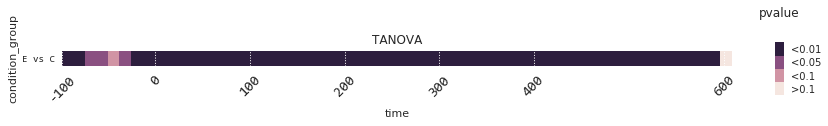

In [12]:
script = {'conditions': 'E vs C:error_response&correct_response',
          'timepoints': '-100~600'}
e = epochs.extract(script)

# t1 = e.tanova(win_size='5ms', shuffle=1000, strategy=1, parallel=True)
# t1.correct(method='cluster').plot()

# t2 = e.tanova(win_size='5ms', shuffle=1000, strategy=2, parallel=True)
# t2.correct(method='cluster').plot()

t3 = e.tanova(win_size='5ms', shuffle=1000, strategy=3, parallel=True)
# t3.default_plot_params['cbar_values']=['1', '2', '3', '4']
t3.correct(method='cluster').plot()